This notebook have significant change from previous version in terms of considering output for each patient, instead of taking output at each visit patient's final status is only considered.Hence input for each patient
is of size maxVisit*features. Assuming 12000 patient and maximum visit is 10 and number of features are 72
input shape to transformer is (10,72) for each patient

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

/home/anuj.birani/.conda/envs/env_anuj2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        #         print("attention score", attn_scores)
        #         print(mask.shape)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        #         print("prob", attn_prob)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        #         print("combining heads ", x.size() )
        #         print("return shape ", x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model).shape)
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        #         print(Q.shape, K.shape, V.shape)

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [3]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, : x.size(1)]

In [5]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [6]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [7]:
# Define the neural network class
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleNN, self).__init__()

        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.output_layer = nn.Linear(hidden_size2, output_size)
        self.soft = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.float()
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        output = torch.sigmoid(self.output_layer(x))
        return output


# Added activation sigmoid instead of relu

In [8]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define network parameters
input_size = 72  # Number of input features
hidden_size1 = 128  # Number of neurons in the first hidden layer
hidden_size2 = 256  # Number of neurons in the second hidden layer
output_size = 512  # Size of the output vector

In [9]:
torch.__version__

'1.13.1+cu117'

Output shape: [8,11,1]
target shape: [8,11]

In [13]:
df = pd.read_csv("../synthetic.csv")
df

,Unnamed: 0,Patient,Date,Pulse,eGFR,Gender,Alcohol,Haemoglobin,Albumin,Age,Status,Alcohol_num,gender_num
0,0,5477,2018-01-02,98,99,F,N,15.09,27.6,31,0,0,1
1,1,4701,2018-01-02,85,22,F,N,16.73,33.8,28,0,0,1
2,2,5724,2018-01-02,76,65,F,N,14.86,38.3,64,0,0,1
3,3,4896,2018-01-04,98,75,M,N,8.51,45.2,45,0,0,0
4,4,5854,2018-01-05,54,39,M,Y,15.04,47.6,85,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6808,6808,5373,2024-03-21,57,110,M,N,13.64,36.4,31,0,0,0
6809,6809,5737,2024-03-30,56,97,M,Y,14.50,25.5,68,0,1,0
6810,6810,4914,2024-04-30,110,87,M,Y,8.61,35.8,38,0,1,0
6811,6811,5191,2024-06-24,61,11,F,N,14.96,33.9,80,0,0,1


In [11]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df.rename(columns={"Patient": "Id"}, inplace=True)

In [12]:
df.drop(["Alcohol", "Gender"], axis=1, inplace=True)

# to add output as last column
status = df["Status"]
df.drop(["Status"], axis=1, inplace=True)
df["Status"] = status

df

,Id,Date,Pulse,eGFR,Haemoglobin,Albumin,Age,Alcohol_num,gender_num,Status
0,5477,2018-01-02,98,99,15.09,27.6,31,0,1,0
1,4701,2018-01-02,85,22,16.73,33.8,28,0,1,0
2,5724,2018-01-02,76,65,14.86,38.3,64,0,1,0
3,4896,2018-01-04,98,75,8.51,45.2,45,0,0,0
4,5854,2018-01-05,54,39,15.04,47.6,85,1,0,0
...,...,...,...,...,...,...,...,...,...,...
6808,5373,2024-03-21,57,110,13.64,36.4,31,0,0,0
6809,5737,2024-03-30,56,97,14.50,25.5,68,1,0,0
6810,4914,2024-04-30,110,87,8.61,35.8,38,1,0,0
6811,5191,2024-06-24,61,11,14.96,33.9,80,0,1,0


In [13]:
dates = df["Date"]
date_time = [pd.to_datetime(date) for date in df["Date"]]

# Date-Time is 13:23:30 2019-7-23
# x = torch.Tensor([[13, 23, 30, 2019, 7, 23]]).float()
# d2v(x)
time_tensor = [
    torch.tensor([0, 0, 0, d.year, d.month, d.day]).float() for d in date_time
]

In [14]:
from Model import Date2VecConvert

# Date2Vec embedder object
# Loads a pretrained model
d2v = Date2VecConvert(model_path="./d2v_model/d2v_98291_17.169918439404636.pth")

# create embedding for each date
embedding = []

for tt in time_tensor:
    embedding.append(d2v(tt))

p = embedding[0]
print(p)

tensor([ 1.5897e+00, -3.2823e+00, -1.8717e+00,  3.6848e+00, -1.0213e+01,
        -4.6613e+01, -3.3032e+00,  2.2100e+00,  1.3304e+00, -8.6733e-02,
        -6.3472e-01,  5.1575e-01, -1.7546e+01, -2.3705e+00, -2.4953e-01,
         1.9109e+00, -1.2022e+01,  1.0986e+00,  1.1586e-01,  1.2141e+00,
        -7.1491e+00, -1.1020e+00,  1.4179e+00,  1.2639e+01,  1.5641e-01,
         1.0400e+01,  1.4795e+01,  1.6048e+00,  3.7290e-02,  4.6288e-01,
         5.0035e+00, -3.7524e+00, -8.8100e-01,  9.0004e-01, -3.3882e-02,
        -4.4998e-01, -4.8311e-01, -5.1259e-01,  3.8442e-01,  9.7673e-01,
        -4.5171e-03,  8.2064e-01,  1.3381e-01, -9.8437e-01,  4.0080e-01,
        -3.9748e-01, -2.8830e-01, -5.5212e-01, -2.5262e-01,  8.5314e-01,
         6.1610e-01,  9.6994e-01, -9.9438e-01,  9.6621e-01, -4.9452e-01,
        -5.3770e-02,  1.6302e-01,  4.2707e-01, -7.7380e-01,  2.7348e-01,
         6.9878e-01, -7.6222e-01,  9.6082e-01, -7.1575e-01])


/home/anuj.birani/.conda/envs/env_anuj2/lib/python3.11/site-packages/torch/serialization.py:888: SourceChangeWarning: source code of class 'Model.Date2Vec' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/anuj.birani/.conda/envs/env_anuj2/lib/python3.11/site-packages/torch/serialization.py:888: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/anuj.birani/.conda/envs/env_anuj2/lib/python3.11/site-packages/torch/serialization.py:888: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the or

In [15]:
num_cols = ["Pulse", "Age", "eGFR", "Haemoglobin", "Albumin"]
# num_cols = ['Pulse', 'Age', 'eGFR', 'Haemoglobin']
data = df.copy()
for col in num_cols:
    data[col] = (data[col] - data[col].min() + 0.0001) / (
        data[col].max() - data[col].min() + 0.0001
    )

data_train = data.drop(["Date"], axis=1)


data_tensor = []
for i, p in enumerate(embedding):
    data_tensor.append(
        torch.cat(
            (
                p,
                torch.tensor(data_train.loc[i]),
            )
        ).float()
    )

data_tensor[0]

tensor([ 1.5897e+00, -3.2823e+00, -1.8717e+00,  3.6848e+00, -1.0213e+01,
        -4.6613e+01, -3.3032e+00,  2.2100e+00,  1.3304e+00, -8.6733e-02,
        -6.3472e-01,  5.1575e-01, -1.7546e+01, -2.3705e+00, -2.4953e-01,
         1.9109e+00, -1.2022e+01,  1.0986e+00,  1.1586e-01,  1.2141e+00,
        -7.1491e+00, -1.1020e+00,  1.4179e+00,  1.2639e+01,  1.5641e-01,
         1.0400e+01,  1.4795e+01,  1.6048e+00,  3.7290e-02,  4.6288e-01,
         5.0035e+00, -3.7524e+00, -8.8100e-01,  9.0004e-01, -3.3882e-02,
        -4.4998e-01, -4.8311e-01, -5.1259e-01,  3.8442e-01,  9.7673e-01,
        -4.5171e-03,  8.2064e-01,  1.3381e-01, -9.8437e-01,  4.0080e-01,
        -3.9748e-01, -2.8830e-01, -5.5212e-01, -2.5262e-01,  8.5314e-01,
         6.1610e-01,  9.6994e-01, -9.9438e-01,  9.6621e-01, -4.9452e-01,
        -5.3770e-02,  1.6302e-01,  4.2707e-01, -7.7380e-01,  2.7348e-01,
         6.9878e-01, -7.6222e-01,  9.6082e-01, -7.1575e-01,  5.4770e+03,
         8.0000e-01,  8.2500e-01,  7.3093e-01,  1.1

In [16]:
# Convert PyTorch tensor to NumPy array
numpy_data = data_tensor

print(numpy_data[0])
tensor_patientId = []
for ind, id in enumerate(df["Id"]):
    tensor_patientId.append((id, data_tensor[ind]))


di = {}
for vals in tensor_patientId:
    if vals[0] in di:
        di[vals[0]].append(vals[1])
    else:
        di[vals[0]] = [vals[1]]

print(len(list(di.keys())))
# print(di)

tensor([ 1.5897e+00, -3.2823e+00, -1.8717e+00,  3.6848e+00, -1.0213e+01,
        -4.6613e+01, -3.3032e+00,  2.2100e+00,  1.3304e+00, -8.6733e-02,
        -6.3472e-01,  5.1575e-01, -1.7546e+01, -2.3705e+00, -2.4953e-01,
         1.9109e+00, -1.2022e+01,  1.0986e+00,  1.1586e-01,  1.2141e+00,
        -7.1491e+00, -1.1020e+00,  1.4179e+00,  1.2639e+01,  1.5641e-01,
         1.0400e+01,  1.4795e+01,  1.6048e+00,  3.7290e-02,  4.6288e-01,
         5.0035e+00, -3.7524e+00, -8.8100e-01,  9.0004e-01, -3.3882e-02,
        -4.4998e-01, -4.8311e-01, -5.1259e-01,  3.8442e-01,  9.7673e-01,
        -4.5171e-03,  8.2064e-01,  1.3381e-01, -9.8437e-01,  4.0080e-01,
        -3.9748e-01, -2.8830e-01, -5.5212e-01, -2.5262e-01,  8.5314e-01,
         6.1610e-01,  9.6994e-01, -9.9438e-01,  9.6621e-01, -4.9452e-01,
        -5.3770e-02,  1.6302e-01,  4.2707e-01, -7.7380e-01,  2.7348e-01,
         6.9878e-01, -7.6222e-01,  9.6082e-01, -7.1575e-01,  5.4770e+03,
         8.0000e-01,  8.2500e-01,  7.3093e-01,  1.1

In [17]:
# store maximimum size, will use for padding

max_visits = 0
# for ki in di.keys():
#     print(len(di[ki]))


max_visits = max([len(di[ki]) for ki in di.keys()])
print("Max visits: ", max_visits)

# len(di[65544][0]) = size of tensor for 1st visit of patient 65544

for patID in di.keys():
    remain_len = max_visits - len(di[patID])
    # 72 is size of tensor for each visit
    feat_size = di[patID][0].shape[0]
    di[patID] = [torch.tensor([0] * feat_size)] * remain_len + di[patID]
#     len = di[ki][0].shape[0]
#     di[ki] = [torch.tensor([0]*)]*72remain_len +di[ki]


# for ki in di.keys():
#     print(len(di[ki]))

Max visits:  10


Total 1500 patients are there and patient visted clinic maximum & minimum 10, 1 time respectively.

In [18]:
# di[5444]

In [19]:
data = pd.DataFrame(di).T
data

,0,1,2,3,4,5,6,7,8,9
5477,"[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1.5897), tensor(-3.2823), tensor(-1.87...","[tensor(1.4455), tensor(-3.1088), tensor(-1.59...","[tensor(1.3576), tensor(-3.0172), tensor(-1.46...","[tensor(1.3390), tensor(-2.9791), tensor(-1.38...","[tensor(1.5688), tensor(-3.2777), tensor(-1.88..."
4701,"[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1.5897), tensor(-3.2823), tensor(-1.87...","[tensor(1.5616), tensor(-3.2413), tensor(-1.79...","[tensor(1.4949), tensor(-3.2212), tensor(-1.83...","[tensor(1.3898), tensor(-2.9945), tensor(-1.35...","[tensor(1.2615), tensor(-2.8258), tensor(-1.07...","[tensor(1.4994), tensor(-3.2242), tensor(-1.83..."
5724,"[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1.5897), tensor(-3.2823), tensor(-1.87...","[tensor(1.4387), tensor(-3.1392), tensor(-1.68...","[tensor(1.3830), tensor(-3.0249), tensor(-1.45...","[tensor(1.3671), tensor(-3.0201), tensor(-1.45..."
4896,"[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1.5834), tensor(-3.2804), tensor(-1.87...","[tensor(1.5452), tensor(-3.2688), tensor(-1.89...","[tensor(1.4106), tensor(-3.0982), tensor(-1.61...","[tensor(1.3299), tensor(-2.9439), tensor(-1.30...","[tensor(1.5720), tensor(-3.2786), tensor(-1.88..."
5854,"[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1.5802), tensor(-3.2794), tensor(-1.87...","[tensor(1.5135), tensor(-3.2593), tensor(-1.91...","[tensor(1.5113), tensor(-3.1936), tensor(-1.73...","[tensor(1.4323), tensor(-3.1373), tensor(-1.69...","[tensor(1.3395), tensor(-2.9468), tensor(-1.29..."
...,...,...,...,...,...,...,...,...,...,...
5453,"[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1.5218), tensor(-3.2686), tensor(-1.91..."
5697,"[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(1.5636), tensor(-3.2487), tensor(-1.80..."
4620,"[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t

In [20]:
# Split the data into train and test sets

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


# print(train_data)
print("Total training data: ", len(train_data))
print("each training data tensor shape: ", train_data.iloc[0,].shape[0])
# Convert NumPy arrays back to PyTorch tensors
print(train_data[0])

Total training data:  1200
each training data tensor shape:  10
5318    [tensor(0), tensor(0), tensor(0), tensor(0), t...
5633    [tensor(0), tensor(0), tensor(0), tensor(0), t...
5896    [tensor(0), tensor(0), tensor(0), tensor(0), t...
5591    [tensor(0), tensor(0), tensor(0), tensor(0), t...
5708    [tensor(0), tensor(0), tensor(0), tensor(0), t...
                              ...                        
4823    [tensor(0), tensor(0), tensor(0), tensor(0), t...
5607    [tensor(0), tensor(0), tensor(0), tensor(0), t...
5032    [tensor(0), tensor(0), tensor(0), tensor(0), t...
4539    [tensor(0), tensor(0), tensor(0), tensor(0), t...
4855    [tensor(0), tensor(0), tensor(0), tensor(0), t...
Name: 0, Length: 1200, dtype: object


Now we have a 512 size tensor for each visit of each patient

In [21]:
df

,Id,Date,Pulse,eGFR,Haemoglobin,Albumin,Age,Alcohol_num,gender_num,Status
0,5477,2018-01-02,98,99,15.09,27.6,31,0,1,0
1,4701,2018-01-02,85,22,16.73,33.8,28,0,1,0
2,5724,2018-01-02,76,65,14.86,38.3,64,0,1,0
3,4896,2018-01-04,98,75,8.51,45.2,45,0,0,0
4,5854,2018-01-05,54,39,15.04,47.6,85,1,0,0
...,...,...,...,...,...,...,...,...,...,...
6808,5373,2024-03-21,57,110,13.64,36.4,31,0,0,0
6809,5737,2024-03-30,56,97,14.50,25.5,68,1,0,0
6810,4914,2024-04-30,110,87,8.61,35.8,38,1,0,0
6811,5191,2024-06-24,61,11,14.96,33.9,80,0,1,0


In [22]:
def data_loader(df):
    data = df.copy()
    print("data shape: ", data.shape)

    y_data = {}

    for patient in data.index:
        # print(train_data.loc[patient])
        maxVisit = data.loc[patient].shape[0]
        y_data[patient] = [0] * maxVisit
        for i, visits in enumerate(data.loc[patient].index):
            visit = data.loc[patient].loc[visits].clone().detach()
            y_data[patient] = visit[-1].item()
            data.loc[patient].loc[visits] = visit[:-1]
            # print(visit)

    li = []
    for key in y_data:
        li.append(y_data[key])

    y_train = torch.tensor(li, dtype=torch.float32)
    #     print(y_train.shape)

    #     print(data.iloc[0][0].shape)
    #     print("shape of data: ",data.shape)
    #     print("size of y_data: ", len(y_data))

    op = []
    for pat in data.index:
        for i, visits in enumerate(data.loc[pat]):
            output_tensor = visits.clone().detach()
            op.append(output_tensor)

    x_data = torch.cat([el for el in op]).view(
        data.shape[0], data.shape[1], data.iloc[0][0].shape[0]
    )
    #   x_train = torch.cat([el for el in op]).view(g.shape[0],g.shape[1],70)
    print(x_data.shape)
    return (x_data, y_train)

In [23]:
x_train, y_train = data_loader(train_data)
x_test, y_test = data_loader(test_data)

data shape:  (1200, 10)
torch.Size([1200, 10, 72])
data shape:  (300, 10)
torch.Size([300, 10, 72])


In [24]:
y_test.shape

torch.Size([300])

In [25]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        tgt_vocab_size,
        d_model,
        num_heads,
        num_layers,
        d_ff,
        max_seq_length,
        dropout,
    ):
        super(Transformer, self).__init__()
        # self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        # self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        # self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.fc = SimpleNN(input_size, hidden_size1, hidden_size2, output_size)

        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        )
        # self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        #         self.dropout = nn.Dropout(dropout)
        #         final_net = nn.Sequential(
        #             nn.Linear(512,128),
        #             nn.Linear(128,32),
        #             nn.Linear(32,1),
        #             nn.Sigmoid()
        #         )
        self.classifier = SimpleNN(512, 128, 32, 1)
        self.final = SimpleNN(10, 16, 8, 1)

        # self.classifier = final_net

    def generate_mask(self, src):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        # tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        # seq_length = tgt.size(1)
        # nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length).to(torch.device('cuda:0')), diagonal=1)).bool()
        # tgt_mask = tgt_mask & nopeak_mask
        # return src_mask, tgt_mask
        return src_mask

    def forward(self, src, tgt=None):
        # src_mask, tgt_mask = self.generate_mask(src, tgt)
        #         src_mask = self.generate_mask(src)
        # src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        src_embedded = self.fc(src)
        # tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        #         print("input to each encoding layer shape: ",enc_output.shape)
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output)

        # print("enc_ouput shape: ",enc_output.shape)
        #         dec_output = tgt_embedded
        #         for dec_layer in self.decoder_layers:
        #             dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        #         output = self.fc(dec_output)
        #         return output
        p = self.classifier(enc_output).squeeze()
        # print("p in transformer class ",p.shape)

        p = self.final(p)

        #         print("p in transformer class ",p.shape)
        return p


# final_net added on 2/10/23 also resolve function added to convert output vector of size 2 to 1(classification)

In [26]:
src_vocab_size = 5
tgt_vocab_size = 5
d_model = 512
num_heads = 8
num_layers = 2
d_ff = 64
max_seq_length = 11
dropout = 0.1
transformer = Transformer(
    src_vocab_size,
    tgt_vocab_size,
    d_model,
    num_heads,
    num_layers,
    d_ff,
    max_seq_length,
    dropout,
).to(torch.device("cuda:0"))
transformer

Transformer(
  (fc): SimpleNN(
    (layer1): Linear(in_features=72, out_features=128, bias=True)
    (layer2): Linear(in_features=128, out_features=256, bias=True)
    (output_layer): Linear(in_features=256, out_features=512, bias=True)
    (soft): Softmax(dim=1)
  )
  (encoder_layers): ModuleList(
    (0-1): 2 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=512, out_features=64, bias=True)
        (fc2): Linear(in_features=64, out_features=512, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  

### Empty model takes 310MiB memory

In [34]:
def find_accuracy(pred, labels):
    #     print(labels.is_cuda, pred.is_cuda)
    #     print(len(labels.flatten()))
    #     print("pred shape: ", pred.shape)

    p = pred.view(-1).detach().clone().to("cpu")
    p = torch.where(p >= 0.5, torch.tensor(1), torch.tensor(0))
    q = labels.flatten()
    precision = precision_score(p, q)
    accu = accuracy_score(p, q)
    f1 = f1_score(p, q)

    return accu, precision, f1

In [35]:
np.random.seed(81)
x_train.to(torch.device("cuda:0"))
y_train.to(torch.device("cuda:0"))

tensor([0., 1., 1.,  ..., 1., 0., 0.], device='cuda:0')

In [31]:
print(sum(y_test))
print(y_test.shape)

tensor(75.)
torch.Size([300])


In [32]:
# Above data takes 20mb

In [33]:
print(
    "% positive sample in test data: ", torch.sum(y_test).item() * 100 / y_test.shape[0]
)

% positive sample in test data:  25.0


In [34]:
# criterion = nn.CrossEntropyLoss(ignore_index=-100)
pos_weight = torch.tensor([4]).to(torch.device("cuda:0"))
criterion = nn.BCELoss(pos_weight, reduction="mean")
optimizer = optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
# optimizer = optim.SGD(transformer.parameters(), lr=0.001, momentum=0.9)
loss_vals = []
test_loss = []
accuracy = []
batch_size = 50

In [35]:
# 330 memory till now

  0%|▏                                          | 1/200 [00:03<10:34,  3.19s/it]

Epoch: 0, Train Loss: 2.2459194660186768
Epoch: 0, Val Loss: 2.275618076324463
Accuracy: 0.75, Precision: 0.0, F1 Score: 0.0


 10%|████▍                                     | 21/200 [00:07<00:40,  4.47it/s]

Epoch: 20, Train Loss: 1.4186385869979858
Epoch: 20, Val Loss: 1.4467765092849731
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 20%|████████▌                                 | 41/200 [00:12<00:34,  4.54it/s]

Epoch: 40, Train Loss: 1.3169175386428833
Epoch: 40, Val Loss: 1.4156312942504883
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 30%|████████████▊                             | 61/200 [00:17<00:33,  4.16it/s]

Epoch: 60, Train Loss: 1.4174015522003174
Epoch: 60, Val Loss: 1.377429485321045
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 40%|█████████████████                         | 81/200 [00:21<00:26,  4.46it/s]

Epoch: 80, Train Loss: 1.8104004859924316
Epoch: 80, Val Loss: 1.3747198581695557
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 50%|████████████████████▋                    | 101/200 [00:26<00:22,  4.49it/s]

Epoch: 100, Train Loss: 1.8331594467163086
Epoch: 100, Val Loss: 1.3633615970611572
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 60%|████████████████████████▊                | 121/200 [00:30<00:17,  4.48it/s]

Epoch: 120, Train Loss: 1.0680639743804932
Epoch: 120, Val Loss: 1.3707923889160156
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 70%|████████████████████████████▉            | 141/200 [00:35<00:13,  4.43it/s]

Epoch: 140, Train Loss: 1.4718890190124512
Epoch: 140, Val Loss: 1.3697509765625
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 80%|█████████████████████████████████        | 161/200 [00:39<00:08,  4.47it/s]

Epoch: 160, Train Loss: 1.660683274269104
Epoch: 160, Val Loss: 1.3700164556503296
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 90%|█████████████████████████████████████    | 181/200 [00:44<00:04,  4.49it/s]

Epoch: 180, Train Loss: 1.5717226266860962
Epoch: 180, Val Loss: 1.375740647315979
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


100%|█████████████████████████████████████████| 200/200 [00:48<00:00,  4.14it/s]


lr =  0.1


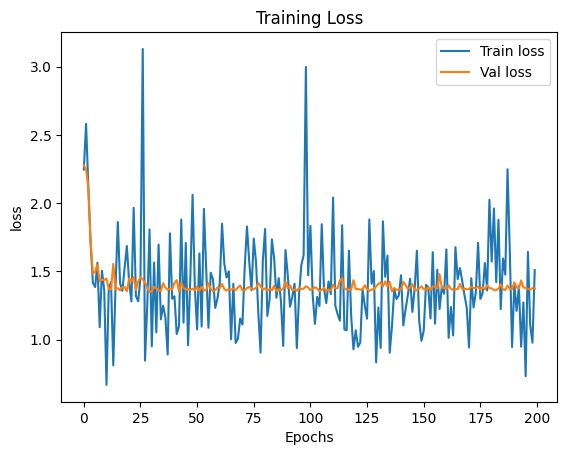

Average accuracy:  85.50666666666667 %


  0%|▏                                          | 1/250 [00:00<00:52,  4.72it/s]

Epoch: 0, Train Loss: 1.191906213760376
Epoch: 0, Val Loss: 1.37399423122406
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


  8%|███▌                                      | 21/250 [00:04<00:51,  4.46it/s]

Epoch: 20, Train Loss: 1.2007912397384644
Epoch: 20, Val Loss: 1.3768024444580078
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 16%|██████▉                                   | 41/250 [00:09<00:46,  4.51it/s]

Epoch: 40, Train Loss: 0.9313030242919922
Epoch: 40, Val Loss: 1.3767938613891602
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 24%|██████████▏                               | 61/250 [00:13<00:42,  4.48it/s]

Epoch: 60, Train Loss: 1.0312817096710205
Epoch: 60, Val Loss: 1.382400631904602
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 32%|█████████████▌                            | 81/250 [00:18<00:37,  4.50it/s]

Epoch: 80, Train Loss: 1.0800046920776367
Epoch: 80, Val Loss: 1.3797303438186646
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 40%|████████████████▌                        | 101/250 [00:22<00:31,  4.79it/s]

Epoch: 100, Train Loss: 1.1551882028579712
Epoch: 100, Val Loss: 1.3819552659988403
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 48%|███████████████████▊                     | 121/250 [00:26<00:28,  4.58it/s]

Epoch: 120, Train Loss: 1.3935511112213135
Epoch: 120, Val Loss: 1.3821690082550049
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 56%|███████████████████████                  | 141/250 [00:31<00:24,  4.47it/s]

Epoch: 140, Train Loss: 1.4741753339767456
Epoch: 140, Val Loss: 1.3835878372192383
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 64%|██████████████████████████▍              | 161/250 [00:35<00:19,  4.50it/s]

Epoch: 160, Train Loss: 1.2250539064407349
Epoch: 160, Val Loss: 1.3851654529571533
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 72%|█████████████████████████████▋           | 181/250 [00:40<00:15,  4.46it/s]

Epoch: 180, Train Loss: 1.4945075511932373
Epoch: 180, Val Loss: 1.387223243713379
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 80%|████████████████████████████████▉        | 201/250 [00:44<00:10,  4.52it/s]

Epoch: 200, Train Loss: 1.6106982231140137
Epoch: 200, Val Loss: 1.3881540298461914
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 88%|████████████████████████████████████▏    | 221/250 [00:49<00:06,  4.46it/s]

Epoch: 220, Train Loss: 1.3165830373764038
Epoch: 220, Val Loss: 1.387565016746521
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 96%|███████████████████████████████████████▌ | 241/250 [00:53<00:01,  4.57it/s]

Epoch: 240, Train Loss: 1.1974915266036987
Epoch: 240, Val Loss: 1.3845680952072144
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


100%|█████████████████████████████████████████| 250/250 [00:55<00:00,  4.50it/s]

lr =  0.01


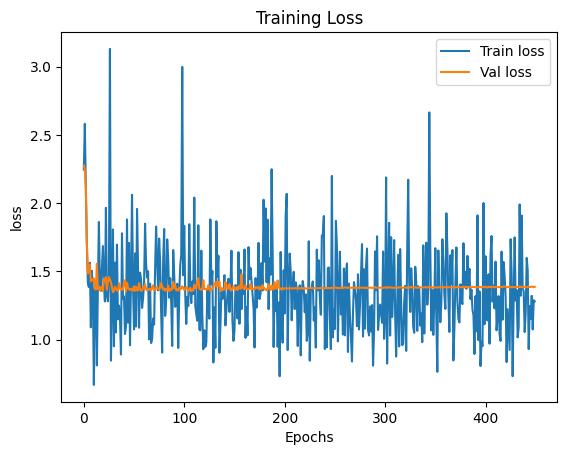

Average accuracy:  85.59555555555556 %


  0%|▏                                          | 1/300 [00:00<01:06,  4.52it/s]

Epoch: 0, Train Loss: 1.507415533065796
Epoch: 0, Val Loss: 1.3867347240447998
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


  7%|██▉                                       | 21/300 [00:04<01:04,  4.30it/s]

Epoch: 20, Train Loss: 0.9712340831756592
Epoch: 20, Val Loss: 1.3878021240234375
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 14%|█████▋                                    | 41/300 [00:09<00:58,  4.42it/s]

Epoch: 40, Train Loss: 1.2006908655166626
Epoch: 40, Val Loss: 1.3871994018554688
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 20%|████████▌                                 | 61/300 [00:13<00:51,  4.67it/s]

Epoch: 60, Train Loss: 1.5616552829742432
Epoch: 60, Val Loss: 1.3885701894760132
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 27%|███████████▎                              | 81/300 [00:18<00:48,  4.54it/s]

Epoch: 80, Train Loss: 1.693163514137268
Epoch: 80, Val Loss: 1.3874913454055786
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 34%|█████████████▊                           | 101/300 [00:22<00:44,  4.50it/s]

Epoch: 100, Train Loss: 1.3916958570480347
Epoch: 100, Val Loss: 1.3871488571166992
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 40%|████████████████▌                        | 121/300 [00:26<00:39,  4.57it/s]

Epoch: 120, Train Loss: 1.495368480682373
Epoch: 120, Val Loss: 1.3879079818725586
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 47%|███████████████████▎                     | 141/300 [00:31<00:35,  4.48it/s]

Epoch: 140, Train Loss: 1.3197102546691895
Epoch: 140, Val Loss: 1.3877813816070557
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 54%|██████████████████████                   | 161/300 [00:35<00:31,  4.48it/s]

Epoch: 160, Train Loss: 1.23077392578125
Epoch: 160, Val Loss: 1.3890469074249268
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 60%|████████████████████████▋                | 181/300 [00:40<00:26,  4.45it/s]

Epoch: 180, Train Loss: 1.1165874004364014
Epoch: 180, Val Loss: 1.3876081705093384
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 67%|███████████████████████████▍             | 201/300 [00:44<00:22,  4.49it/s]

Epoch: 200, Train Loss: 1.6258600950241089
Epoch: 200, Val Loss: 1.3902192115783691
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 74%|██████████████████████████████▏          | 221/300 [00:49<00:17,  4.47it/s]

Epoch: 220, Train Loss: 1.2115039825439453
Epoch: 220, Val Loss: 1.3884190320968628
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 80%|████████████████████████████████▉        | 241/300 [00:53<00:13,  4.51it/s]

Epoch: 240, Train Loss: 1.001050591468811
Epoch: 240, Val Loss: 1.389971137046814
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 87%|███████████████████████████████████▋     | 261/300 [00:57<00:08,  4.59it/s]

Epoch: 260, Train Loss: 1.0924632549285889
Epoch: 260, Val Loss: 1.3892910480499268
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 94%|██████████████████████████████████████▌  | 282/300 [01:01<00:02,  7.80it/s]

Epoch: 280, Train Loss: 0.8938633799552917
Epoch: 280, Val Loss: 1.388634443283081
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


100%|█████████████████████████████████████████| 300/300 [01:03<00:00,  4.75it/s]


lr =  0.003


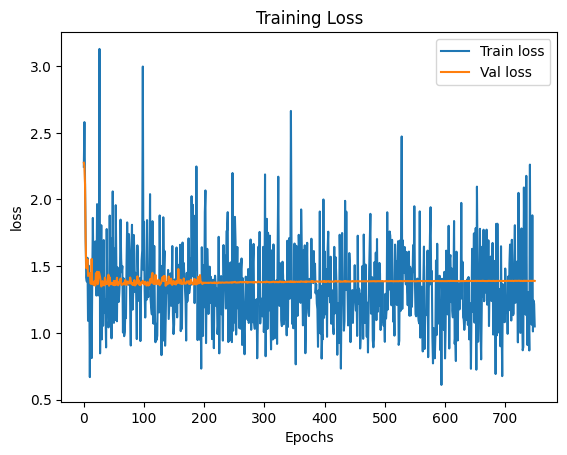

Average accuracy:  85.62400000000001 %


  0%|                                           | 1/350 [00:00<00:39,  8.91it/s]

Epoch: 0, Train Loss: 0.9391719102859497
Epoch: 0, Val Loss: 1.3895591497421265
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


  6%|██▋                                       | 22/350 [00:02<00:34,  9.38it/s]

Epoch: 20, Train Loss: 0.9616955518722534
Epoch: 20, Val Loss: 1.3896116018295288
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 12%|█████                                     | 42/350 [00:04<00:32,  9.44it/s]

Epoch: 40, Train Loss: 1.2610132694244385
Epoch: 40, Val Loss: 1.3897428512573242
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 18%|███████▍                                  | 62/350 [00:06<00:30,  9.46it/s]

Epoch: 60, Train Loss: 1.2353965044021606
Epoch: 60, Val Loss: 1.389792561531067
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 23%|█████████▊                                | 82/350 [00:08<00:28,  9.50it/s]

Epoch: 80, Train Loss: 0.8587075471878052
Epoch: 80, Val Loss: 1.3898570537567139
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 29%|███████████▉                             | 102/350 [00:10<00:26,  9.47it/s]

Epoch: 100, Train Loss: 1.5475072860717773
Epoch: 100, Val Loss: 1.3899040222167969
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 35%|██████████████▎                          | 122/350 [00:12<00:23,  9.87it/s]

Epoch: 120, Train Loss: 1.6450936794281006
Epoch: 120, Val Loss: 1.389931321144104
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 41%|████████████████▊                        | 143/350 [00:14<00:20,  9.97it/s]

Epoch: 140, Train Loss: 0.8067196607589722
Epoch: 140, Val Loss: 1.3899589776992798
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 46%|██████████████████▉                      | 162/350 [00:16<00:19,  9.56it/s]

Epoch: 160, Train Loss: 0.7227296829223633
Epoch: 160, Val Loss: 1.3900041580200195
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 52%|█████████████████████▎                   | 182/350 [00:19<00:17,  9.50it/s]

Epoch: 180, Train Loss: 1.4667813777923584
Epoch: 180, Val Loss: 1.3900604248046875
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 58%|███████████████████████▋                 | 202/350 [00:21<00:15,  9.57it/s]

Epoch: 200, Train Loss: 1.116347074508667
Epoch: 200, Val Loss: 1.3900710344314575
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 63%|██████████████████████████               | 222/350 [00:23<00:13,  9.53it/s]

Epoch: 220, Train Loss: 0.9663508534431458
Epoch: 220, Val Loss: 1.3900964260101318
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 69%|████████████████████████████▏            | 241/350 [00:25<00:14,  7.40it/s]

Epoch: 240, Train Loss: 0.7383232712745667
Epoch: 240, Val Loss: 1.3901252746582031
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 75%|██████████████████████████████▌          | 261/350 [00:29<00:19,  4.45it/s]

Epoch: 260, Train Loss: 1.2402641773223877
Epoch: 260, Val Loss: 1.3901605606079102
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 80%|████████████████████████████████▉        | 281/350 [00:34<00:15,  4.46it/s]

Epoch: 280, Train Loss: 1.4992866516113281
Epoch: 280, Val Loss: 1.3901408910751343
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 86%|███████████████████████████████████▎     | 301/350 [00:38<00:10,  4.48it/s]

Epoch: 300, Train Loss: 1.0517863035202026
Epoch: 300, Val Loss: 1.3901467323303223
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 92%|█████████████████████████████████████▌   | 321/350 [00:43<00:06,  4.50it/s]

Epoch: 320, Train Loss: 1.458959937095642
Epoch: 320, Val Loss: 1.3901803493499756
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 97%|███████████████████████████████████████▉ | 341/350 [00:47<00:02,  4.44it/s]

Epoch: 340, Train Loss: 1.7638061046600342
Epoch: 340, Val Loss: 1.3902348279953003
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


100%|█████████████████████████████████████████| 350/350 [00:49<00:00,  7.06it/s]

lr =  0.0001


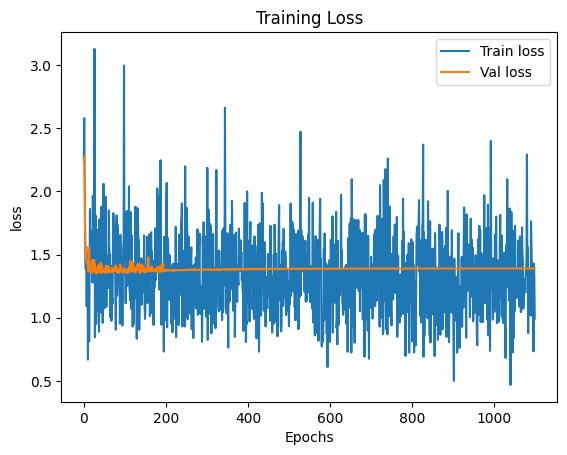

Average accuracy:  85.63757575757576 %
CPU times: user 1h 8min 23s, sys: 4.21 s, total: 1h 8min 27s
Wall time: 3min 37s


In [36]:
%%time
# with torch.autograd.set_detect_anomaly(True):
lr_vals = [0.1, 0.01, 0.003, 0.0001]
epoch_vals = [200, 250, 300, 350]
for k in range(len(lr_vals)):
    transformer.train()
    optimizer = optim.SGD(transformer.parameters(), lr=lr_vals[k], momentum=0.8)
    #         optimizer = optim.Adam(transformer.parameters(), lr=0.01, betas=(0.9, 0.98), eps=1e-9)

    for epoch in tqdm(range(epoch_vals[k])):
        permutation = torch.randperm(x_train.size()[0])
        epoch_loss = 0
        epoch_output = torch.tensor([]).to(torch.device("cuda:0"))
        for i in range(0, x_train.size()[0], batch_size):
            optimizer.zero_grad()
            indices = permutation[i : i + batch_size]
            batch_x, batch_y = x_train[indices].to(torch.device("cuda:0")), y_train[
                indices
            ].to(torch.device("cuda:0"))
            # no change in memory from above code
            #         print("batch_y : ", sum(batch_y).item()) (okay, 1/5th are +ve )

            output = transformer(batch_x, batch_y)
            # above operation takes 34 mb memory (364)

            epoch_output = torch.cat((epoch_output, output), axis=0)

            # above operation takes 20 mb memory (384)

            #         print("epoch output shape",epoch_output.shape)
            #         print("output: \n",output)
            loss = criterion(output.view(-1), batch_y.view(-1).to("cuda:0"))
            epoch_loss += loss.detach().item()

            loss.backward()
            optimizer.step()

        #         print(x_train.dtype)
        #         print(x_train.requires_grad)
        #         print("y_train shape",y_train.shape)
        #         print(output[0])

        #     break  #(392mb)

        test_op = transformer(x_test.to(torch.device("cuda:0")), y_test)
        #         accuracy = accuracy_score(test_op.cpu().detach().numpy(), y_test.cpu().detach().numpy())

        # break  (512mb)
        t_loss = criterion(test_op.view(-1), y_test.view(-1).to("cuda:0")).detach()

        #         print("output shape: ",epoch_outpt.shape)
        accu, precision, f1 = find_accuracy(test_op, y_test)
        accuracy.append(accu.item())

        test_loss.append(t_loss)
        #     loss = criterion(output.contiguous().view(88, -1), y_train.flatten().to(torch.device('cuda:0')))
        loss_vals.append(loss.item())
        if (epoch) % 20 == 0:
            print(f"Epoch: {epoch}, Train Loss: {loss.item()}")
            print(f"Epoch: {epoch}, Val Loss: {t_loss.item()}")
            print(f"Accuracy: {accu}, Precision: {precision}, F1 Score: {f1}")

    print("lr = ", lr_vals[k])
    plt.plot([l for l in loss_vals])
    plt.plot([l.item() for l in test_loss])
    plt.legend(["Train loss", "Val loss"])
    plt.ylabel("loss")
    plt.xlabel("Epochs")
    plt.title("Training Loss")
    plt.show()
    print("Average accuracy: ", np.mean(accuracy) * 100, "%")

  0%|▍                                                                                  | 1/200 [00:00<01:37,  2.05it/s]

Epoch: 0, Train Loss: 1.9694058895111084
Epoch: 0, Val Loss: 2.2522175312042236
Accuracy: 0.75, Precision: 0.0, F1 Score: 0.0


 10%|████████▌                                                                         | 21/200 [00:05<00:41,  4.36it/s]

Epoch: 20, Train Loss: 1.6032531261444092
Epoch: 20, Val Loss: 1.412589192390442
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 20%|████████████████▊                                                                 | 41/200 [00:10<00:37,  4.25it/s]

Epoch: 40, Train Loss: 1.1279269456863403
Epoch: 40, Val Loss: 1.3707410097122192
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 30%|█████████████████████████                                                         | 61/200 [00:14<00:31,  4.37it/s]

Epoch: 60, Train Loss: 0.9806081652641296
Epoch: 60, Val Loss: 1.360213041305542
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 40%|█████████████████████████████████▏                                                | 81/200 [00:19<00:27,  4.28it/s]

Epoch: 80, Train Loss: 1.1398766040802002
Epoch: 80, Val Loss: 1.3588427305221558
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 50%|████████████████████████████████████████▉                                        | 101/200 [00:24<00:23,  4.25it/s]

Epoch: 100, Train Loss: 0.8384983539581299
Epoch: 100, Val Loss: 1.3584562540054321
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 60%|█████████████████████████████████████████████████                                | 121/200 [00:28<00:18,  4.25it/s]

Epoch: 120, Train Loss: 0.6651450991630554
Epoch: 120, Val Loss: 1.5012407302856445
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 70%|█████████████████████████████████████████████████████████                        | 141/200 [00:33<00:13,  4.45it/s]

Epoch: 140, Train Loss: 1.3625054359436035
Epoch: 140, Val Loss: 1.362756371498108
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 80%|█████████████████████████████████████████████████████████████████▏               | 161/200 [00:37<00:08,  4.37it/s]

Epoch: 160, Train Loss: 1.115964651107788
Epoch: 160, Val Loss: 1.4279050827026367
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 90%|█████████████████████████████████████████████████████████████████████████▎       | 181/200 [00:42<00:04,  4.43it/s]

Epoch: 180, Train Loss: 1.341823697090149
Epoch: 180, Val Loss: 1.3755074739456177
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:46<00:00,  4.26it/s]

lr =  0.1


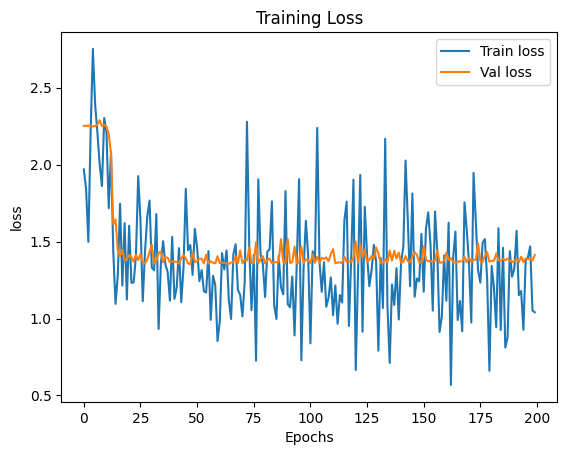

Average accuracy:  84.94333333333334 %


  0%|▎                                                                                  | 1/250 [00:00<00:59,  4.21it/s]

Epoch: 0, Train Loss: 1.8645681142807007
Epoch: 0, Val Loss: 1.3748090267181396
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


  8%|██████▉                                                                           | 21/250 [00:04<00:53,  4.30it/s]

Epoch: 20, Train Loss: 1.2708615064620972
Epoch: 20, Val Loss: 1.3687403202056885
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 16%|█████████████▍                                                                    | 41/250 [00:09<00:48,  4.33it/s]

Epoch: 40, Train Loss: 1.5395541191101074
Epoch: 40, Val Loss: 1.3719542026519775
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 25%|████████████████████▎                                                             | 62/250 [00:12<00:22,  8.39it/s]

Epoch: 60, Train Loss: 1.3209846019744873
Epoch: 60, Val Loss: 1.3701395988464355
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 33%|███████████████████████████▏                                                      | 83/250 [00:14<00:17,  9.56it/s]

Epoch: 80, Train Loss: 1.5750312805175781
Epoch: 80, Val Loss: 1.377893090248108
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 41%|█████████████████████████████████                                                | 102/250 [00:16<00:16,  9.06it/s]

Epoch: 100, Train Loss: 1.409814715385437
Epoch: 100, Val Loss: 1.371824026107788
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 49%|███████████████████████████████████████▌                                         | 122/250 [00:18<00:14,  8.83it/s]

Epoch: 120, Train Loss: 0.9591435194015503
Epoch: 120, Val Loss: 1.3721472024917603
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 57%|██████████████████████████████████████████████                                   | 142/250 [00:21<00:12,  8.53it/s]

Epoch: 140, Train Loss: 2.3695919513702393
Epoch: 140, Val Loss: 1.3769546747207642
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 65%|████████████████████████████████████████████████████▍                            | 162/250 [00:23<00:09,  9.00it/s]

Epoch: 160, Train Loss: 1.3630422353744507
Epoch: 160, Val Loss: 1.37576425075531
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [00:25<00:07,  9.23it/s]

Epoch: 180, Train Loss: 1.4510372877120972
Epoch: 180, Val Loss: 1.3765499591827393
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [00:28<00:06,  7.94it/s]

Epoch: 200, Train Loss: 1.1539993286132812
Epoch: 200, Val Loss: 1.3775014877319336
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [00:30<00:03,  8.63it/s]

Epoch: 220, Train Loss: 1.1184083223342896
Epoch: 220, Val Loss: 1.374526023864746
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [00:33<00:00,  9.02it/s]

Epoch: 240, Train Loss: 1.469556212425232
Epoch: 240, Val Loss: 1.3802440166473389
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.35it/s]

lr =  0.01


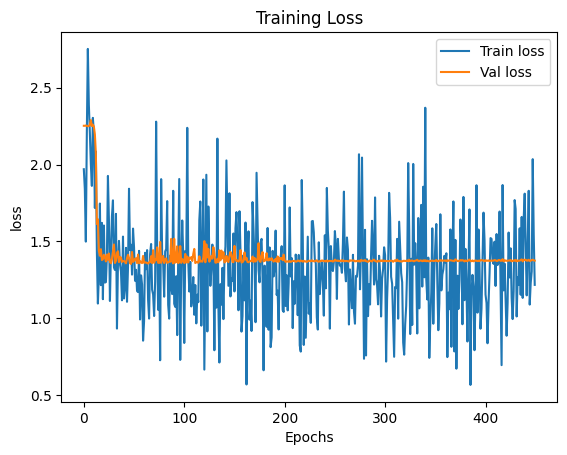

Average accuracy:  85.3451851851852 %


  0%|▎                                                                                  | 1/300 [00:00<00:35,  8.50it/s]

Epoch: 0, Train Loss: 1.21262526512146
Epoch: 0, Val Loss: 1.374536395072937
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


  7%|██████                                                                            | 22/300 [00:02<00:34,  8.16it/s]

Epoch: 20, Train Loss: 1.196141004562378
Epoch: 20, Val Loss: 1.3760592937469482
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 14%|███████████▍                                                                      | 42/300 [00:05<00:32,  7.86it/s]

Epoch: 40, Train Loss: 1.0443764925003052
Epoch: 40, Val Loss: 1.374938726425171
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 21%|████████████████▉                                                                 | 62/300 [00:07<00:26,  8.88it/s]

Epoch: 60, Train Loss: 1.2756696939468384
Epoch: 60, Val Loss: 1.3750135898590088
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 27%|██████████████████████▍                                                           | 82/300 [00:09<00:23,  9.19it/s]

Epoch: 80, Train Loss: 0.8809272646903992
Epoch: 80, Val Loss: 1.3757559061050415
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 34%|███████████████████████████▌                                                     | 102/300 [00:11<00:21,  9.18it/s]

Epoch: 100, Train Loss: 1.4678928852081299
Epoch: 100, Val Loss: 1.3760931491851807
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 41%|████████████████████████████████▉                                                | 122/300 [00:13<00:19,  9.17it/s]

Epoch: 120, Train Loss: 1.4094287157058716
Epoch: 120, Val Loss: 1.377657413482666
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 47%|██████████████████████████████████████                                           | 141/300 [00:17<00:36,  4.37it/s]

Epoch: 140, Train Loss: 1.128991723060608
Epoch: 140, Val Loss: 1.3767468929290771
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 54%|███████████████████████████████████████████▍                                     | 161/300 [00:21<00:32,  4.26it/s]

Epoch: 160, Train Loss: 1.419710397720337
Epoch: 160, Val Loss: 1.3767086267471313
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 60%|████████████████████████████████████████████████▊                                | 181/300 [00:26<00:27,  4.29it/s]

Epoch: 180, Train Loss: 1.4468212127685547
Epoch: 180, Val Loss: 1.3755884170532227
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 67%|██████████████████████████████████████████████████████▎                          | 201/300 [00:31<00:22,  4.33it/s]

Epoch: 200, Train Loss: 1.2192482948303223
Epoch: 200, Val Loss: 1.3771759271621704
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 74%|███████████████████████████████████████████████████████████▋                     | 221/300 [00:36<00:18,  4.26it/s]

Epoch: 220, Train Loss: 1.547322392463684
Epoch: 220, Val Loss: 1.377112627029419
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 80%|█████████████████████████████████████████████████████████████████                | 241/300 [00:40<00:13,  4.41it/s]

Epoch: 240, Train Loss: 1.306447148323059
Epoch: 240, Val Loss: 1.3765009641647339
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 87%|██████████████████████████████████████████████████████████████████████▍          | 261/300 [00:45<00:09,  4.29it/s]

Epoch: 260, Train Loss: 1.3268413543701172
Epoch: 260, Val Loss: 1.377478003501892
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 94%|███████████████████████████████████████████████████████████████████████████▊     | 281/300 [00:49<00:04,  4.23it/s]

Epoch: 280, Train Loss: 1.1732741594314575
Epoch: 280, Val Loss: 1.3763384819030762
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.52it/s]

lr =  0.003


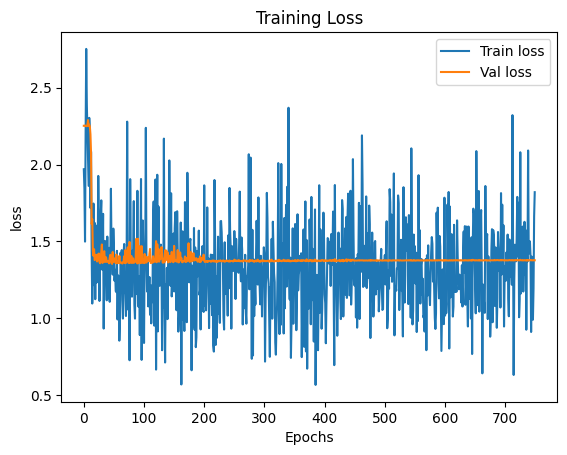

Average accuracy:  85.47377777777777 %


  0%|▏                                                                                  | 1/350 [00:00<01:23,  4.20it/s]

Epoch: 0, Train Loss: 1.9116140604019165
Epoch: 0, Val Loss: 1.377164602279663
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


  6%|████▉                                                                             | 21/350 [00:04<01:16,  4.28it/s]

Epoch: 20, Train Loss: 1.451080322265625
Epoch: 20, Val Loss: 1.3771637678146362
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 12%|█████████▊                                                                        | 42/350 [00:09<01:06,  4.64it/s]

Epoch: 40, Train Loss: 2.475734233856201
Epoch: 40, Val Loss: 1.3771928548812866
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 17%|██████████████▎                                                                   | 61/350 [00:14<01:04,  4.49it/s]

Epoch: 60, Train Loss: 1.6121784448623657
Epoch: 60, Val Loss: 1.3771108388900757
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 23%|██████████████████▉                                                               | 81/350 [00:18<01:00,  4.43it/s]

Epoch: 80, Train Loss: 1.814268708229065
Epoch: 80, Val Loss: 1.377174973487854
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 29%|███████████████████████▎                                                         | 101/350 [00:23<00:55,  4.45it/s]

Epoch: 100, Train Loss: 1.043407917022705
Epoch: 100, Val Loss: 1.3771181106567383
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 35%|████████████████████████████                                                     | 121/350 [00:27<00:51,  4.45it/s]

Epoch: 120, Train Loss: 1.3326674699783325
Epoch: 120, Val Loss: 1.3770809173583984
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 40%|████████████████████████████████▋                                                | 141/350 [00:32<00:46,  4.47it/s]

Epoch: 140, Train Loss: 0.8647271394729614
Epoch: 140, Val Loss: 1.3771878480911255
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 46%|█████████████████████████████████████▎                                           | 161/350 [00:36<00:42,  4.48it/s]

Epoch: 160, Train Loss: 0.8683239817619324
Epoch: 160, Val Loss: 1.377189040184021
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 52%|█████████████████████████████████████████▉                                       | 181/350 [00:40<00:38,  4.41it/s]

Epoch: 180, Train Loss: 1.3295246362686157
Epoch: 180, Val Loss: 1.3771905899047852
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 57%|██████████████████████████████████████████████▌                                  | 201/350 [00:45<00:33,  4.42it/s]

Epoch: 200, Train Loss: 1.1572637557983398
Epoch: 200, Val Loss: 1.3772214651107788
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 63%|███████████████████████████████████████████████████▏                             | 221/350 [00:49<00:29,  4.44it/s]

Epoch: 220, Train Loss: 1.2453830242156982
Epoch: 220, Val Loss: 1.3772510290145874
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 69%|███████████████████████████████████████████████████████▊                         | 241/350 [00:54<00:24,  4.42it/s]

Epoch: 240, Train Loss: 1.5717577934265137
Epoch: 240, Val Loss: 1.377188801765442
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 75%|████████████████████████████████████████████████████████████▍                    | 261/350 [00:58<00:19,  4.46it/s]

Epoch: 260, Train Loss: 1.141021728515625
Epoch: 260, Val Loss: 1.3772112131118774
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 80%|█████████████████████████████████████████████████████████████████                | 281/350 [01:03<00:15,  4.55it/s]

Epoch: 280, Train Loss: 1.2015832662582397
Epoch: 280, Val Loss: 1.377247929573059
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 86%|█████████████████████████████████████████████████████████████████████▋           | 301/350 [01:07<00:11,  4.45it/s]

Epoch: 300, Train Loss: 1.488279104232788
Epoch: 300, Val Loss: 1.3772811889648438
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 92%|██████████████████████████████████████████████████████████████████████████▎      | 321/350 [01:12<00:06,  4.44it/s]

Epoch: 320, Train Loss: 1.5760993957519531
Epoch: 320, Val Loss: 1.377194881439209
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 97%|██████████████████████████████████████████████████████████████████████████████▉  | 341/350 [01:16<00:02,  4.46it/s]

Epoch: 340, Train Loss: 1.9118456840515137
Epoch: 340, Val Loss: 1.3772813081741333
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


100%|█████████████████████████████████████████████████████████████████████████████████| 350/350 [01:18<00:00,  4.44it/s]

lr =  0.0001


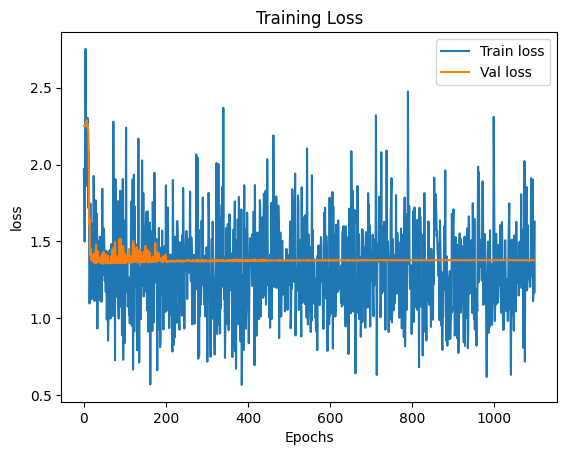

Average accuracy:  85.53515151515151 %
CPU times: user 1h 8min 11s, sys: 4.17 s, total: 1h 8min 15s
Wall time: 3min 34s


In [48]:
%%time
# with torch.autograd.set_detect_anomaly(True):
lr_vals = [0.1, 0.01, 0.003, 0.0001]
epoch_vals = [200, 250, 300, 350]
for k in range(len(lr_vals)):
    transformer.train()
    optimizer = optim.SGD(transformer.parameters(), lr=lr_vals[k], momentum=0.8)
    #         optimizer = optim.Adam(transformer.parameters(), lr=0.01, betas=(0.9, 0.98), eps=1e-9)

    for epoch in tqdm(range(epoch_vals[k])):
        permutation = torch.randperm(x_train.size()[0])
        epoch_loss = 0
        epoch_output = torch.tensor([]).to(torch.device("cuda:0"))
        for i in range(0, x_train.size()[0], batch_size):
            optimizer.zero_grad()
            indices = permutation[i : i + batch_size]
            batch_x, batch_y = x_train[indices].to(torch.device("cuda:0")), y_train[
                indices
            ].to(torch.device("cuda:0"))
            # no change in memory from above code
            #         print("batch_y : ", sum(batch_y).item()) (okay, 1/5th are +ve )

            output = transformer(batch_x, batch_y)
            # above operation takes 34 mb memory (364)

            epoch_output = torch.cat((epoch_output, output), axis=0)

            # above operation takes 20 mb memory (384)

            #         print("epoch output shape",epoch_output.shape)
            #         print("output: \n",output)
            loss = criterion(output.view(-1), batch_y.view(-1).to("cuda:0"))
            epoch_loss += loss.detach().item()

            loss.backward()
            optimizer.step()

        #         print(x_train.dtype)
        #         print(x_train.requires_grad)
        #         print("y_train shape",y_train.shape)
        #         print(output[0])

        #     break  #(392mb)

        test_op = transformer(x_test.to(torch.device("cuda:0")), y_test)
        #         accuracy = accuracy_score(test_op.cpu().detach().numpy(), y_test.cpu().detach().numpy())

        # break  (512mb)
        t_loss = criterion(test_op.view(-1), y_test.view(-1).to("cuda:0")).detach()

        #         print("output shape: ",epoch_outpt.shape)
        accu, precision, f1 = find_accuracy(test_op, y_test)
        accuracy.append(accu.item())

        test_loss.append(t_loss)
        #     loss = criterion(output.contiguous().view(88, -1), y_train.flatten().to(torch.device('cuda:0')))
        loss_vals.append(loss.item())
        if (epoch) % 20 == 0:
            print(f"Epoch: {epoch}, Train Loss: {loss.item()}")
            print(f"Epoch: {epoch}, Val Loss: {t_loss.item()}")
            print(f"Accuracy: {accu}, Precision: {precision}, F1 Score: {f1}")

    print("lr = ", lr_vals[k])
    plt.plot([l for l in loss_vals])
    plt.plot([l.item() for l in test_loss])
    plt.legend(["Train loss", "Val loss"])
    plt.ylabel("loss")
    plt.xlabel("Epochs")
    plt.title("Training Loss")
    plt.show()
    print("Average accuracy: ", np.mean(accuracy) * 100, "%")

  0%|▍                                                                                  | 1/200 [00:00<01:45,  1.88it/s]

Epoch: 0, Train Loss: 2.2459194660186768
Epoch: 0, Val Loss: 2.275618076324463
Accuracy: 0.75, Precision: 0.0, F1 Score: 0.0


 10%|████████▌                                                                         | 21/200 [00:05<00:37,  4.79it/s]

Epoch: 20, Train Loss: 1.9500185251235962
Epoch: 20, Val Loss: 1.5777777433395386
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 20%|████████████████▊                                                                 | 41/200 [00:09<00:35,  4.54it/s]

Epoch: 40, Train Loss: 1.7097707986831665
Epoch: 40, Val Loss: 1.583838701248169
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 30%|█████████████████████████                                                         | 61/200 [00:13<00:30,  4.55it/s]

Epoch: 60, Train Loss: 2.0555827617645264
Epoch: 60, Val Loss: 1.5749993324279785
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 40%|█████████████████████████████████▏                                                | 81/200 [00:17<00:25,  4.66it/s]

Epoch: 80, Train Loss: 1.7013720273971558
Epoch: 80, Val Loss: 1.5737546682357788
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 50%|████████████████████████████████████████▉                                        | 101/200 [00:22<00:21,  4.57it/s]

Epoch: 100, Train Loss: 2.2012224197387695
Epoch: 100, Val Loss: 1.5754377841949463
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 60%|█████████████████████████████████████████████████                                | 121/200 [00:26<00:16,  4.75it/s]

Epoch: 120, Train Loss: 1.5560247898101807
Epoch: 120, Val Loss: 1.5739890336990356
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 70%|█████████████████████████████████████████████████████████                        | 141/200 [00:30<00:13,  4.53it/s]

Epoch: 140, Train Loss: 1.8410875797271729
Epoch: 140, Val Loss: 1.575676441192627
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 80%|█████████████████████████████████████████████████████████████████▏               | 161/200 [00:35<00:08,  4.58it/s]

Epoch: 160, Train Loss: 1.9768518209457397
Epoch: 160, Val Loss: 1.5830011367797852
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 90%|█████████████████████████████████████████████████████████████████████████▎       | 181/200 [00:39<00:04,  4.45it/s]

Epoch: 180, Train Loss: 1.8238734006881714
Epoch: 180, Val Loss: 1.5790667533874512
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.57it/s]

lr =  0.1


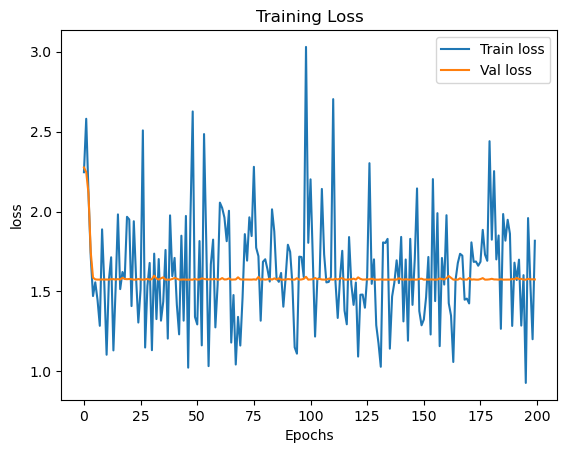

Average accuracy:  85.50666666666667 %


  0%|▎                                                                                  | 1/250 [00:00<00:51,  4.80it/s]

Epoch: 0, Train Loss: 1.5693942308425903
Epoch: 0, Val Loss: 1.5744155645370483
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


  9%|███████▏                                                                          | 22/250 [00:04<00:46,  4.92it/s]

Epoch: 20, Train Loss: 1.542372703552246
Epoch: 20, Val Loss: 1.5738916397094727
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 16%|█████████████▍                                                                    | 41/250 [00:08<00:43,  4.82it/s]

Epoch: 40, Train Loss: 1.3060537576675415
Epoch: 40, Val Loss: 1.5737441778182983
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 24%|████████████████████                                                              | 61/250 [00:13<00:41,  4.59it/s]

Epoch: 60, Train Loss: 1.2616124153137207
Epoch: 60, Val Loss: 1.57380211353302
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 33%|██████████████████████████▉                                                       | 82/250 [00:17<00:34,  4.87it/s]

Epoch: 80, Train Loss: 1.143300175666809
Epoch: 80, Val Loss: 1.5737663507461548
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 40%|████████████████████████████████▋                                                | 101/250 [00:21<00:32,  4.52it/s]

Epoch: 100, Train Loss: 1.556048035621643
Epoch: 100, Val Loss: 1.5738749504089355
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 48%|███████████████████████████████████████▏                                         | 121/250 [00:26<00:28,  4.53it/s]

Epoch: 120, Train Loss: 1.7312371730804443
Epoch: 120, Val Loss: 1.57382333278656
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 57%|██████████████████████████████████████████████                                   | 142/250 [00:30<00:21,  4.98it/s]

Epoch: 140, Train Loss: 1.7038304805755615
Epoch: 140, Val Loss: 1.5738226175308228
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 64%|████████████████████████████████████████████████████▏                            | 161/250 [00:34<00:19,  4.56it/s]

Epoch: 160, Train Loss: 1.3674678802490234
Epoch: 160, Val Loss: 1.5737829208374023
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [00:39<00:15,  4.53it/s]

Epoch: 180, Train Loss: 1.68983793258667
Epoch: 180, Val Loss: 1.5738216638565063
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [00:43<00:10,  4.75it/s]

Epoch: 200, Train Loss: 1.5560956001281738
Epoch: 200, Val Loss: 1.5738121271133423
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [00:48<00:06,  4.68it/s]

Epoch: 220, Train Loss: 1.4083231687545776
Epoch: 220, Val Loss: 1.5738322734832764
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [00:52<00:01,  4.64it/s]

Epoch: 240, Train Loss: 1.3182318210601807
Epoch: 240, Val Loss: 1.5737618207931519
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [00:54<00:00,  4.60it/s]

lr =  0.01


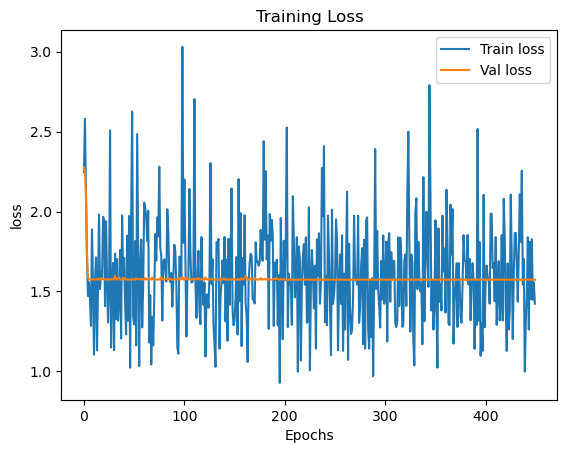

Average accuracy:  85.59555555555556 %


  0%|▎                                                                                  | 1/300 [00:00<00:56,  5.26it/s]

Epoch: 0, Train Loss: 1.73093843460083
Epoch: 0, Val Loss: 1.5737614631652832
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


  7%|█████▋                                                                            | 21/300 [00:04<00:57,  4.82it/s]

Epoch: 20, Train Loss: 1.2744801044464111
Epoch: 20, Val Loss: 1.5738288164138794
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 14%|███████████▏                                                                      | 41/300 [00:08<00:53,  4.84it/s]

Epoch: 40, Train Loss: 1.4775621891021729
Epoch: 40, Val Loss: 1.5738104581832886
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 20%|████████████████▋                                                                 | 61/300 [00:13<00:52,  4.59it/s]

Epoch: 60, Train Loss: 1.9448237419128418
Epoch: 60, Val Loss: 1.5738524198532104
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 27%|██████████████████████▏                                                           | 81/300 [00:17<00:47,  4.61it/s]

Epoch: 80, Train Loss: 2.1990468502044678
Epoch: 80, Val Loss: 1.5738437175750732
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 34%|███████████████████████████▎                                                     | 101/300 [00:21<00:43,  4.60it/s]

Epoch: 100, Train Loss: 1.7970778942108154
Epoch: 100, Val Loss: 1.5738544464111328
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 40%|████████████████████████████████▋                                                | 121/300 [00:26<00:39,  4.55it/s]

Epoch: 120, Train Loss: 1.9856020212173462
Epoch: 120, Val Loss: 1.5738389492034912
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 47%|██████████████████████████████████████                                           | 141/300 [00:30<00:35,  4.53it/s]

Epoch: 140, Train Loss: 1.5698827505111694
Epoch: 140, Val Loss: 1.5738112926483154
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 54%|███████████████████████████████████████████▍                                     | 161/300 [00:34<00:30,  4.61it/s]

Epoch: 160, Train Loss: 1.4084324836730957
Epoch: 160, Val Loss: 1.5738279819488525
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 60%|████████████████████████████████████████████████▊                                | 181/300 [00:39<00:27,  4.40it/s]

Epoch: 180, Train Loss: 1.2890161275863647
Epoch: 180, Val Loss: 1.573797583580017
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 67%|██████████████████████████████████████████████████████▎                          | 201/300 [00:43<00:21,  4.56it/s]

Epoch: 200, Train Loss: 1.93056058883667
Epoch: 200, Val Loss: 1.5738344192504883
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 74%|███████████████████████████████████████████████████████████▋                     | 221/300 [00:47<00:17,  4.53it/s]

Epoch: 220, Train Loss: 1.450384497642517
Epoch: 220, Val Loss: 1.573787808418274
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 80%|█████████████████████████████████████████████████████████████████                | 241/300 [00:52<00:13,  4.46it/s]

Epoch: 240, Train Loss: 1.1272562742233276
Epoch: 240, Val Loss: 1.5738165378570557
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 87%|██████████████████████████████████████████████████████████████████████▍          | 261/300 [00:56<00:08,  4.48it/s]

Epoch: 260, Train Loss: 1.4086939096450806
Epoch: 260, Val Loss: 1.5738041400909424
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 94%|███████████████████████████████████████████████████████████████████████████▊     | 281/300 [01:00<00:04,  4.55it/s]

Epoch: 280, Train Loss: 1.0359514951705933
Epoch: 280, Val Loss: 1.5737919807434082
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [01:05<00:00,  4.61it/s]

lr =  0.003


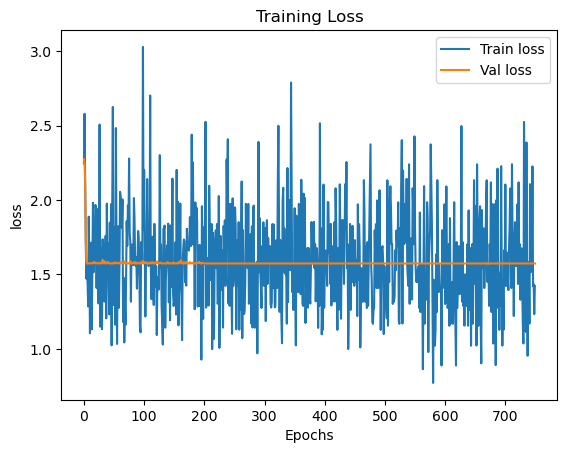

Average accuracy:  85.62400000000001 %


  0%|▏                                                                                  | 1/350 [00:00<01:06,  5.28it/s]

Epoch: 0, Train Loss: 1.408686637878418
Epoch: 0, Val Loss: 1.5738004446029663
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


  6%|████▉                                                                             | 21/350 [00:04<01:07,  4.87it/s]

Epoch: 20, Train Loss: 1.408673644065857
Epoch: 20, Val Loss: 1.573801875114441
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 12%|█████████▌                                                                        | 41/350 [00:08<01:05,  4.70it/s]

Epoch: 40, Train Loss: 1.3576264381408691
Epoch: 40, Val Loss: 1.573805809020996
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 17%|██████████████▎                                                                   | 61/350 [00:12<01:03,  4.56it/s]

Epoch: 60, Train Loss: 1.1825642585754395
Epoch: 60, Val Loss: 1.5738064050674438
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 23%|███████████████████▏                                                              | 82/350 [00:17<00:57,  4.67it/s]

Epoch: 80, Train Loss: 0.8600341081619263
Epoch: 80, Val Loss: 1.573806643486023
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 29%|███████████████████████▎                                                         | 101/350 [00:21<00:53,  4.64it/s]

Epoch: 100, Train Loss: 1.8511799573898315
Epoch: 100, Val Loss: 1.5738121271133423
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 35%|████████████████████████████▏                                                    | 122/350 [00:26<00:48,  4.75it/s]

Epoch: 120, Train Loss: 1.9436663389205933
Epoch: 120, Val Loss: 1.5738130807876587
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 40%|████████████████████████████████▋                                                | 141/350 [00:30<00:45,  4.64it/s]

Epoch: 140, Train Loss: 1.18232262134552
Epoch: 140, Val Loss: 1.573813557624817
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 46%|█████████████████████████████████████▎                                           | 161/350 [00:34<00:39,  4.77it/s]

Epoch: 160, Train Loss: 0.8734440207481384
Epoch: 160, Val Loss: 1.5738139152526855
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 52%|█████████████████████████████████████████▉                                       | 181/350 [00:39<00:36,  4.61it/s]

Epoch: 180, Train Loss: 1.8099501132965088
Epoch: 180, Val Loss: 1.5738164186477661
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 58%|██████████████████████████████████████████████▋                                  | 202/350 [00:43<00:30,  4.81it/s]

Epoch: 200, Train Loss: 1.2609699964523315
Epoch: 200, Val Loss: 1.5738164186477661
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 63%|███████████████████████████████████████████████████▍                             | 222/350 [00:47<00:27,  4.65it/s]

Epoch: 220, Train Loss: 1.2884613275527954
Epoch: 220, Val Loss: 1.5738180875778198
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 69%|███████████████████████████████████████████████████████▊                         | 241/350 [00:52<00:23,  4.73it/s]

Epoch: 240, Train Loss: 0.9145036339759827
Epoch: 240, Val Loss: 1.573818564414978
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 75%|████████████████████████████████████████████████████████████▍                    | 261/350 [00:56<00:19,  4.65it/s]

Epoch: 260, Train Loss: 1.3160037994384766
Epoch: 260, Val Loss: 1.5738177299499512
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 81%|█████████████████████████████████████████████████████████████████▎               | 282/350 [01:00<00:14,  4.71it/s]

Epoch: 280, Train Loss: 1.7037014961242676
Epoch: 280, Val Loss: 1.5738204717636108
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 86%|█████████████████████████████████████████████████████████████████████▉           | 302/350 [01:05<00:09,  4.81it/s]

Epoch: 300, Train Loss: 1.4497877359390259
Epoch: 300, Val Loss: 1.573819875717163
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 92%|██████████████████████████████████████████████████████████████████████████▎      | 321/350 [01:09<00:06,  4.72it/s]

Epoch: 320, Train Loss: 1.6899584531784058
Epoch: 320, Val Loss: 1.573822259902954
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


 98%|███████████████████████████████████████████████████████████████████████████████▏ | 342/350 [01:13<00:01,  6.43it/s]

Epoch: 340, Train Loss: 2.239107370376587
Epoch: 340, Val Loss: 1.5738214254379272
Accuracy: 0.8566666666666667, Precision: 0.4266666666666667, F1 Score: 0.5981308411214953


100%|█████████████████████████████████████████████████████████████████████████████████| 350/350 [01:14<00:00,  4.67it/s]


lr =  0.0001


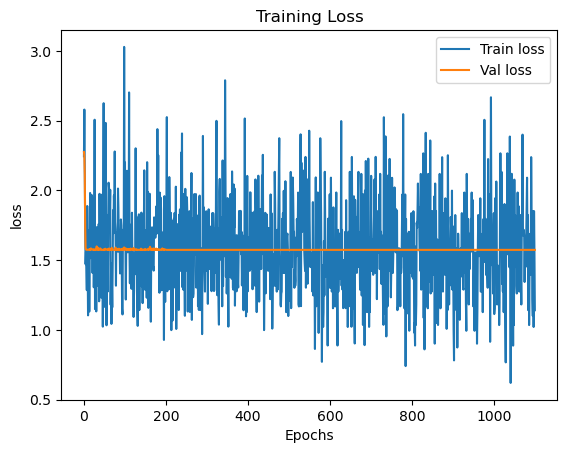

Average accuracy:  85.63757575757576 %
CPU times: user 1h 12min 14s, sys: 3.37 s, total: 1h 12min 18s
Wall time: 3min 58s


In [36]:
%%time
# with torch.autograd.set_detect_anomaly(True):
lr_vals = [0.1, 0.01, 0.003, 0.0001]
epoch_vals = [200, 250, 300, 350]
for k in range(len(lr_vals)):
    transformer.train()
    optimizer = optim.SGD(transformer.parameters(), lr=lr_vals[k], momentum=0.8)
    #         optimizer = optim.Adam(transformer.parameters(), lr=0.01, betas=(0.9, 0.98), eps=1e-9)

    for epoch in tqdm(range(epoch_vals[k])):
        permutation = torch.randperm(x_train.size()[0])
        epoch_loss = 0
        epoch_output = torch.tensor([]).to(torch.device("cuda:0"))
        for i in range(0, x_train.size()[0], batch_size):
            optimizer.zero_grad()
            indices = permutation[i : i + batch_size]
            batch_x, batch_y = x_train[indices].to(torch.device("cuda:0")), y_train[
                indices
            ].to(torch.device("cuda:0"))
            # no change in memory from above code
            #         print("batch_y : ", sum(batch_y).item()) (okay, 1/5th are +ve )

            output = transformer(batch_x, batch_y)
            # above operation takes 34 mb memory (364)

            epoch_output = torch.cat((epoch_output, output), axis=0)

            # above operation takes 20 mb memory (384)

            #         print("epoch output shape",epoch_output.shape)
            #         print("output: \n",output)
            loss = criterion(output.view(-1), batch_y.view(-1).to("cuda:0"))
            epoch_loss += loss.detach().item()

            loss.backward()
            optimizer.step()

        #         print(x_train.dtype)
        #         print(x_train.requires_grad)
        #         print("y_train shape",y_train.shape)
        #         print(output[0])

        #     break  #(392mb)

        test_op = transformer(x_test.to(torch.device("cuda:0")), y_test)
        #         accuracy = accuracy_score(test_op.cpu().detach().numpy(), y_test.cpu().detach().numpy())

        # break  (512mb)
        t_loss = criterion(test_op.view(-1), y_test.view(-1).to("cuda:0")).detach()

        #         print("output shape: ",epoch_outpt.shape)
        accu, precision, f1 = find_accuracy(test_op, y_test)
        accuracy.append(accu.item())

        test_loss.append(t_loss)
        #     loss = criterion(output.contiguous().view(88, -1), y_train.flatten().to(torch.device('cuda:0')))
        loss_vals.append(loss.item())
        if (epoch) % 20 == 0:
            print(f"Epoch: {epoch}, Train Loss: {loss.item()}")
            print(f"Epoch: {epoch}, Val Loss: {t_loss.item()}")
            print(f"Accuracy: {accu}, Precision: {precision}, F1 Score: {f1}")

    print("lr = ", lr_vals[k])
    plt.plot([l for l in loss_vals])
    plt.plot([l.item() for l in test_loss])
    plt.legend(["Train loss", "Val loss"])
    plt.ylabel("loss")
    plt.xlabel("Epochs")
    plt.title("Training Loss")
    plt.show()
    print("Average accuracy: ", np.mean(accuracy) * 100, "%")

In [37]:
for i in range(test_op.shape[0]):
    print(y_test[i].item(), "|||||", test_op[i].item())

0.0 ||||| 0.15800543129444122
1.0 ||||| 0.9999903440475464
0.0 ||||| 0.15800543129444122
0.0 ||||| 0.15800543129444122
0.0 ||||| 0.15800543129444122
0.0 ||||| 0.15800543129444122
0.0 ||||| 0.15800543129444122
0.0 ||||| 0.15800543129444122
1.0 ||||| 0.9999904632568359
1.0 ||||| 0.15800543129444122
1.0 ||||| 0.15800543129444122
1.0 ||||| 0.15800543129444122
0.0 ||||| 0.15800543129444122
1.0 ||||| 0.9999904632568359
0.0 ||||| 0.15800543129444122
0.0 ||||| 0.15800543129444122
1.0 ||||| 0.9999904632568359
1.0 ||||| 0.15800543129444122
0.0 ||||| 0.15800543129444122
0.0 ||||| 0.15800543129444122
0.0 ||||| 0.15800543129444122
1.0 ||||| 0.15800543129444122
0.0 ||||| 0.15800543129444122
0.0 ||||| 0.15800543129444122
0.0 ||||| 0.15800543129444122
0.0 ||||| 0.15800543129444122
0.0 ||||| 0.15800543129444122
1.0 ||||| 0.15800543129444122
1.0 ||||| 0.9999903440475464
0.0 ||||| 0.15800543129444122
1.0 ||||| 0.9999903440475464
0.0 ||||| 0.15800543129444122
0.0 ||||| 0.15800543129444122
1.0 ||||| 0.9999

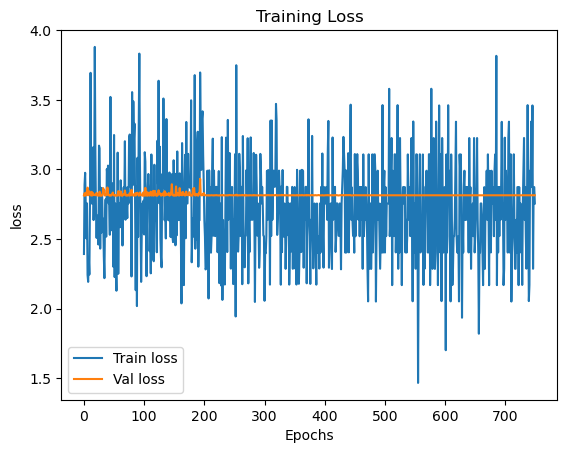

In [56]:
# with weight=4 in loss function
plt.plot([l for l in loss_vals])
plt.plot([l.item() for l in test_loss])
plt.legend(["Train loss", "Val loss"])
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.title("Training Loss")
plt.show()

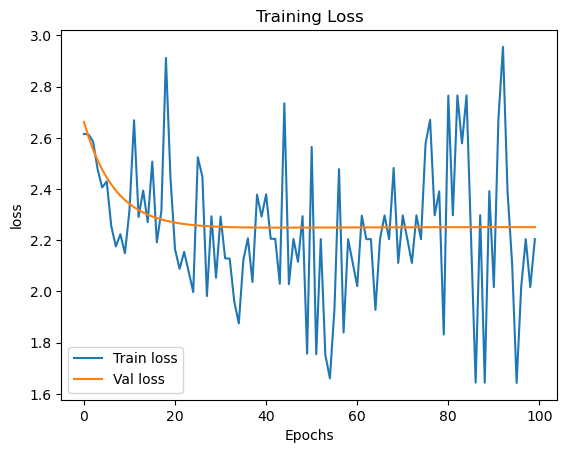

In [36]:
# with weight=4 in loss function
plt.plot([l for l in loss_vals])
plt.plot([l.item() for l in test_loss])
plt.legend(["Train loss", "Val loss"])
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.title("Training Loss")
plt.show()

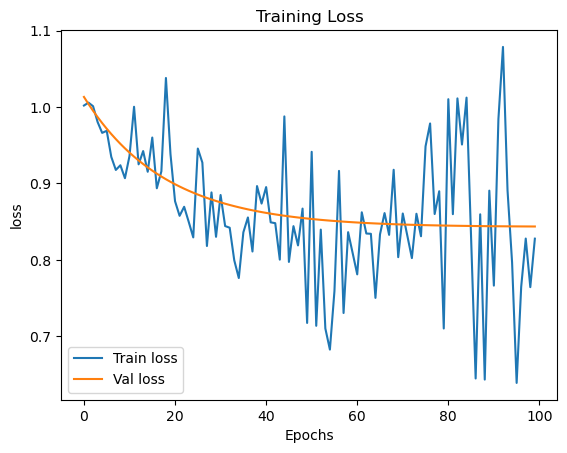

In [37]:
# with weight=1.5 in loss function
plt.plot([l for l in loss_vals])
plt.plot([l.item() for l in test_loss])
plt.legend(["Train loss", "Val loss"])
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.title("Training Loss")
plt.show()

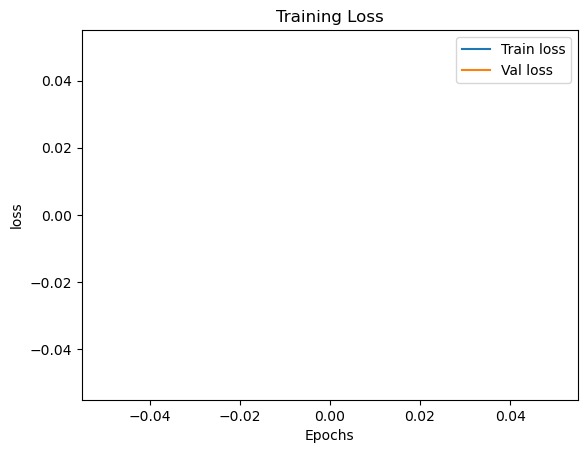

In [134]:
# with weight=2 in loss function
plt.plot([l for l in loss_vals])
plt.plot([l.item() for l in test_loss])
plt.legend(["Train loss", "Val loss"])
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.title("Training Loss")
plt.show()

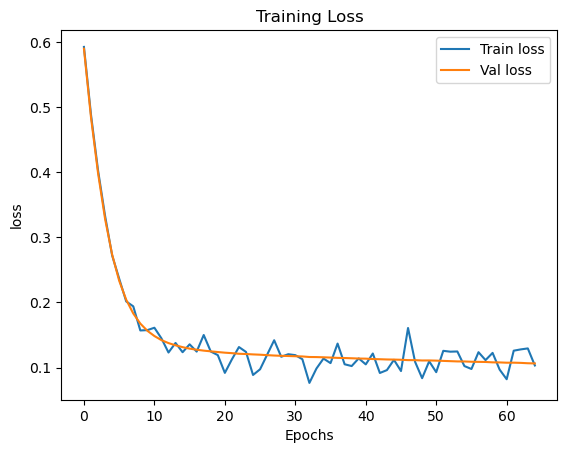

In [29]:
# with no weight in loss function
plt.plot([l for l in loss_vals])
plt.plot([l.item() for l in test_loss])
plt.legend(["Train loss", "Val loss"])
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.title("Training Loss")
plt.show()

In [40]:
from sklearn.metrics import roc_auc_score, roc_curve

In [38]:
from sksurv import metrics

In [ ]:
# df['Date'] = pd.to_datetime(df['Date'])

# for id in df['Id']:
#     print(id)
#     single_patient = df[df['Id']==id].sort_values(by=['Date'])
#     t = single_patient['Date'].shift(periods=1)
#     print(t)

In [31]:
# for i in range(y_train.shape[0]):
#     if y_train[i][-2]==1:
#         print(y_train[i])
#         break

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])


In [87]:
test_op.shape

torch.Size([300, 10, 1])

In [100]:
for i, op in enumerate(test_op):
    k = 0
    for j in range(0, test_op.shape[0]):
        if j != i:
            t = sum(op <= test_op[j]).item()
            #         print("times ith patient have lesser risk than jth patient: ",t)
            if t > 5:
                k += 1

    print("Patient no ", i + 1, "have lesser risk than ", k, "patients")
#         print(test_op[j])

Patient no  1 have lesser risk than  135 patients
Patient no  2 have lesser risk than  95 patients
Patient no  3 have lesser risk than  110 patients
Patient no  4 have lesser risk than  121 patients
Patient no  5 have lesser risk than  108 patients
Patient no  6 have lesser risk than  181 patients
Patient no  7 have lesser risk than  50 patients
Patient no  8 have lesser risk than  175 patients
Patient no  9 have lesser risk than  70 patients
Patient no  10 have lesser risk than  229 patients
Patient no  11 have lesser risk than  205 patients
Patient no  12 have lesser risk than  237 patients
Patient no  13 have lesser risk than  72 patients
Patient no  14 have lesser risk than  76 patients
Patient no  15 have lesser risk than  154 patients
Patient no  16 have lesser risk than  168 patients
Patient no  17 have lesser risk than  87 patients
Patient no  18 have lesser risk than  122 patients
Patient no  19 have lesser risk than  156 patients
Patient no  20 have lesser risk than  98 patie